<a href="https://colab.research.google.com/github/fjadidi2001/AD_Prediction/blob/main/AD_Ad0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mounting Instructions for Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Importing Required Libraries

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score
import itertools

# Setting Random Seeds for Reproducibility in NumPy and TensorFlow

In [5]:
np.random.seed(42)
tf.random.set_seed(42)

> used to make sure that the randomness in NumPy and TensorFlow is consistent across different runs of the program, enabling reproducibility.

In [4]:
# Update the data directory to point to your Google Drive
data_dir = '/content/drive/MyDrive/ADNI'

# Loading Image Data from Directory

In [6]:
# Load data
def load_data(data_dir):
    images, labels = [], []
    for label in os.listdir(data_dir):
        label_dir = os.path.join(data_dir, label)
        for image_file in os.listdir(label_dir):
            image_path = os.path.join(label_dir, image_file)
            image = tf.keras.preprocessing.image.load_img(image_path, target_size=(64, 64))
            image = tf.keras.preprocessing.image.img_to_array(image)
            images.append(image)
            labels.append(label)
    images = np.array(images)
    labels = np.array(labels)
    return images, labels

# Loading and One-Hot Encoding Labels for Image Data

In [7]:
images, labels = load_data(data_dir)
labels = np.where(labels == 'AD', 1, 0)
one_hot = np.zeros((labels.shape[0], 2))
one_hot[np.arange(labels.shape[0]), labels] = 1
labels = one_hot

In [8]:
print(labels)

[[0. 1.]
 [0. 1.]
 [0. 1.]
 ...
 [1. 0.]
 [1. 0.]
 [1. 0.]]


# Splitting Data into Training, Validation, and Test Sets

In [9]:
# Train-validation-test split
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.05, random_state=42, stratify=labels)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42, stratify=y_train)

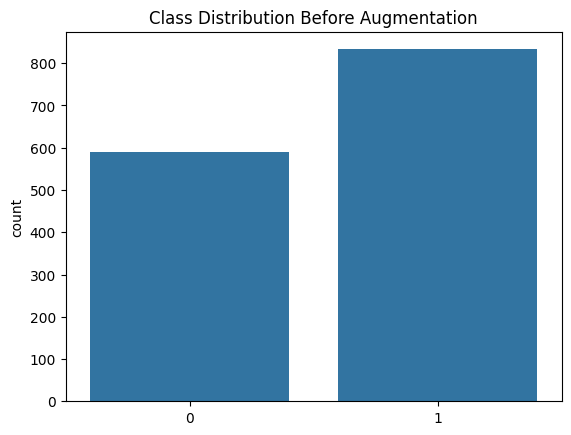

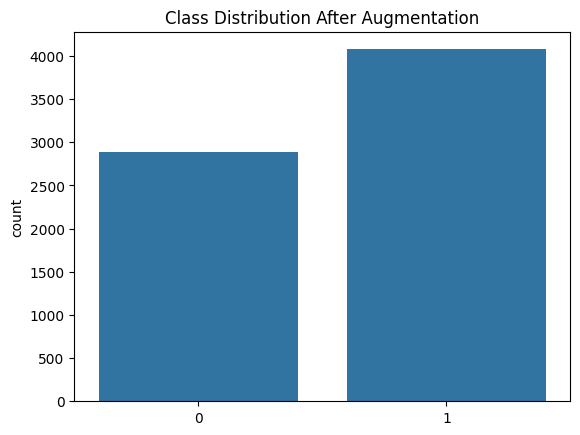

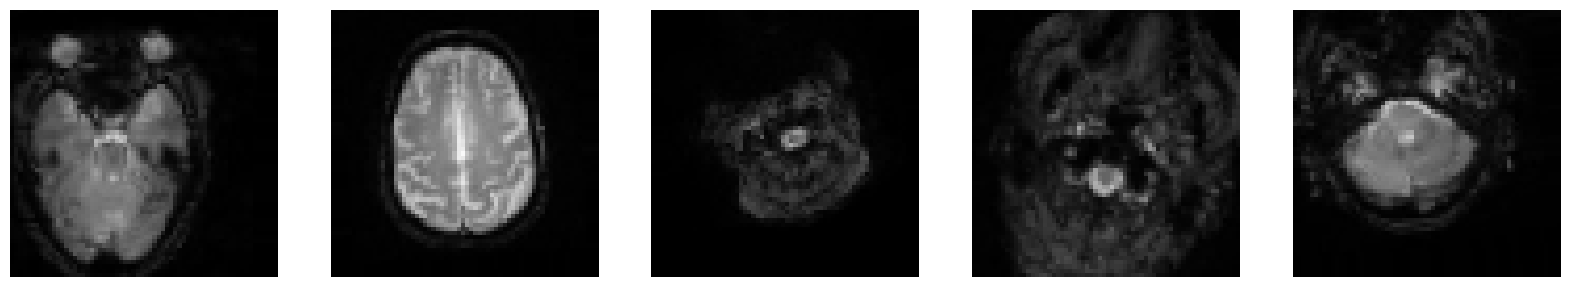

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Training Proposed Model...
Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5620 - loss: 0.6844
Epoch 1: val_loss improved from inf to 0.67410, saving model to best_model.keras
23/23 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.5628 - loss: 0.6842 - val_accuracy: 0.5886 - val_loss: 0.6741
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5949 - loss: 0.6694
Epoch 2: val_loss improved from 0.67410 to 0.64945, saving model to best_model.keras
23/23 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.5945 - loss: 0.6694 - val_accuracy: 0.5759 - val_loss: 0.6494
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6185 - loss: 0.6604
Epoch 3: val_loss improved from 0.64945 to 0.64243, saving model to best_model.keras
23/23 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.6178 - loss: 0.6606 - val_accuracy: 0.6329 - val_loss: 0.6424
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6260 - loss: 0.6550
Epoch 4: val_loss did not improve from 0.64243
23/23 ━━━━━━━━━━━━━━━━━━━━ 27s 1s

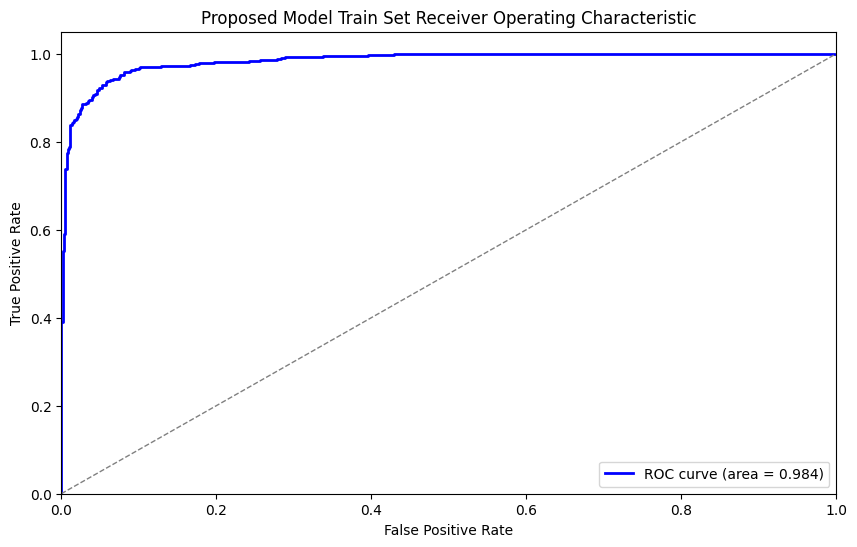

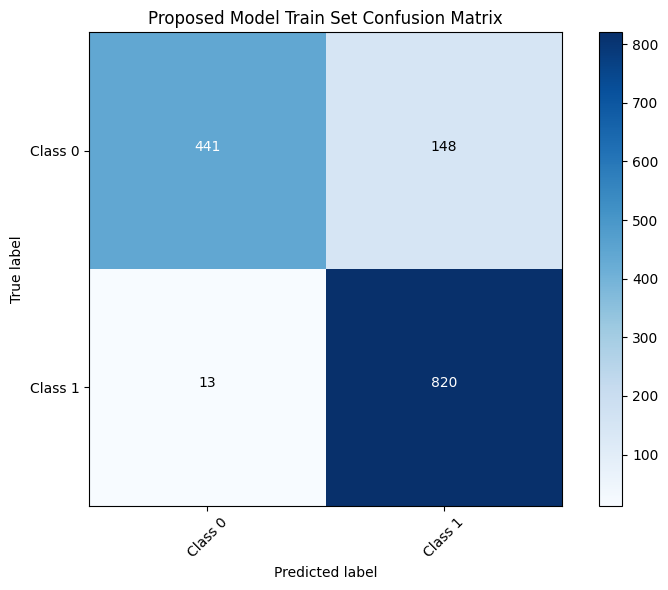

Accuracy: 88.68
Precision: 84.71
Recall: 98.44
F1 Score: 0.911
AUC: 0.984
Loss: 0.233
Evaluating Proposed Model on Validation set...
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 321ms/step - accuracy: 0.8318 - loss: 0.4055
Test accuracy: 0.8354430198669434 Test loss: 0.38779738545417786
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 280ms/step


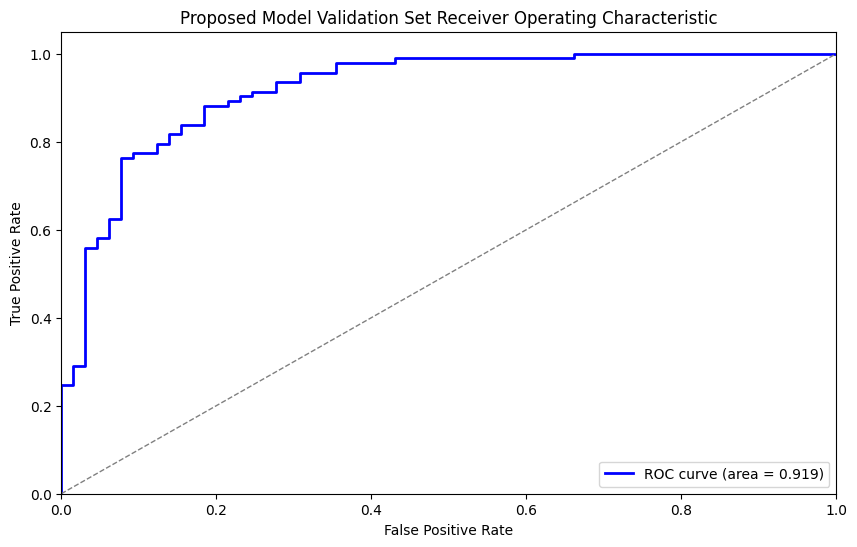

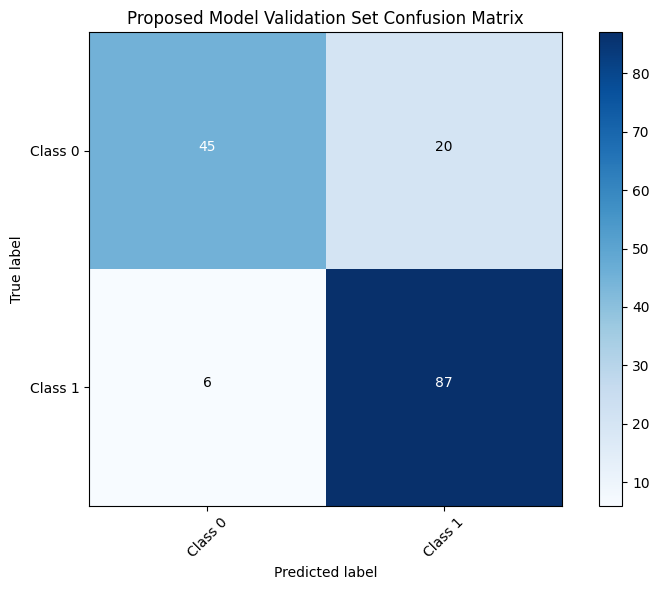

Accuracy: 83.54
Precision: 81.31
Recall: 93.55
F1 Score: 0.870
AUC: 0.919
Loss: 0.388
Evaluating Proposed Model on Test set...


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.8395 - loss: 0.3444
Test accuracy: 0.8452380895614624 Test loss: 0.3343333899974823
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


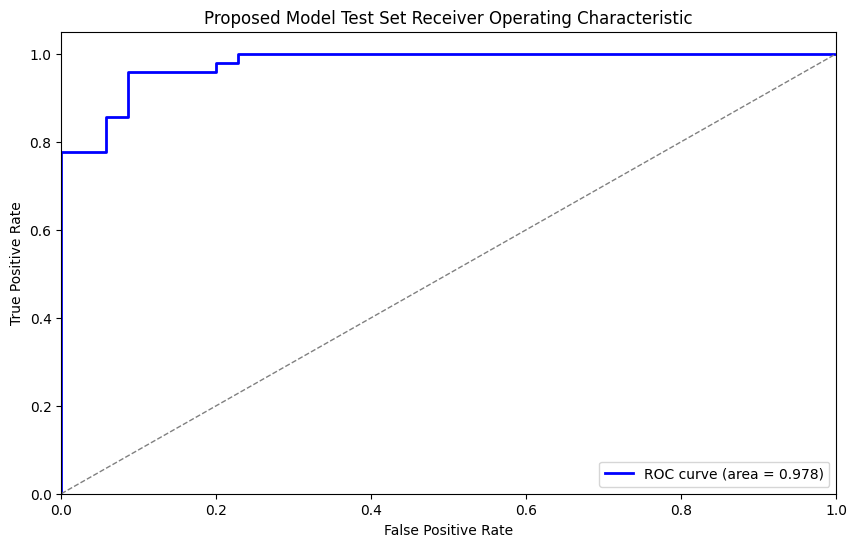

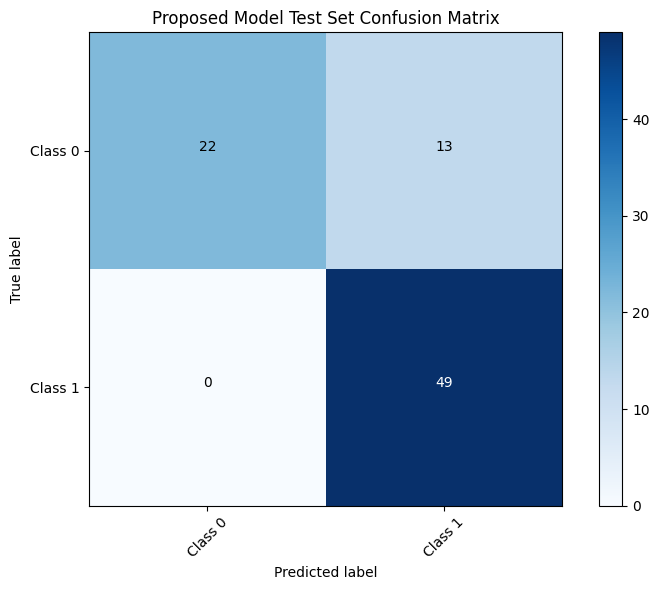

Accuracy: 84.52
Precision: 79.03
Recall: 100.00
F1 Score: 0.883
AUC: 0.978
Loss: 0.334
Plotting history for Proposed Model...


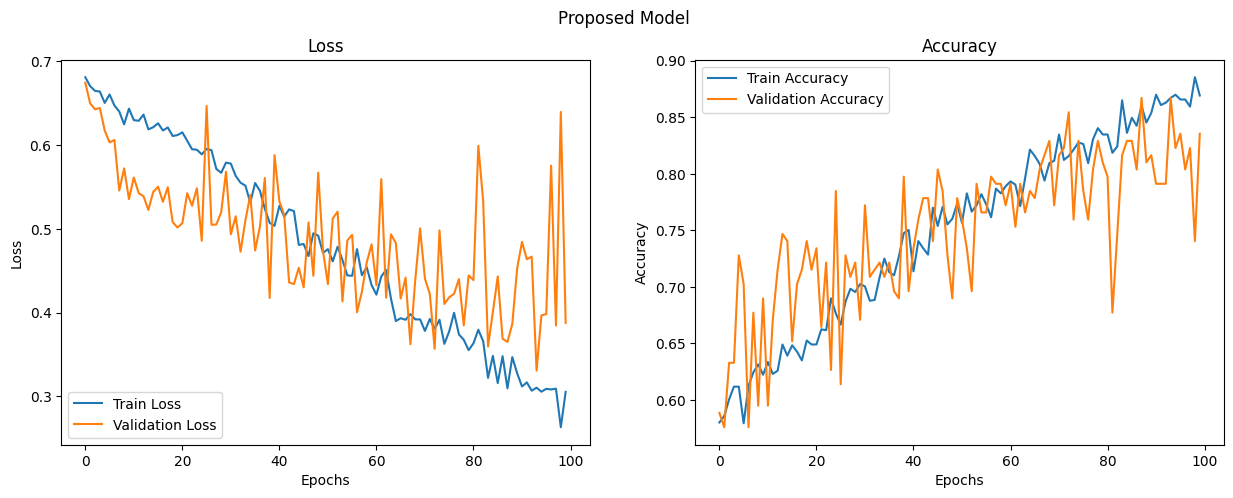

Training Testing Model 1...
Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step - accuracy: 0.5633 - loss: 0.7866
Epoch 1: val_loss did not improve from 0.33084
23/23 ━━━━━━━━━━━━━━━━━━━━ 13s 470ms/step - accuracy: 0.5641 - loss: 0.7837 - val_accuracy: 0.5886 - val_loss: 0.6699
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step - accuracy: 0.6092 - loss: 0.6646
Epoch 2: val_loss did not improve from 0.33084
23/23 ━━━━━━━━━━━━━━━━━━━━ 9s 374ms/step - accuracy: 0.6090 - loss: 0.6649 - val_accuracy: 0.5886 - val_loss: 0.6544
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step - accuracy: 0.6129 - loss: 0.6580
Epoch 3: val_loss did not improve from 0.33084
23/23 ━━━━━━━━━━━━━━━━━━━━ 12s 407ms/step - accuracy: 0.6125 - loss: 0.6582 - val_accuracy: 0.6772 - val_loss: 0.6412
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step - accuracy: 0.6066 - loss: 0.6556
Epoch 4: val_loss did not improve from 0.33084
23/23 ━━━━━━━━━━━━━━━━━━━━ 12s 471ms/step - accuracy: 0.6070 - loss: 0.6554 - val_a

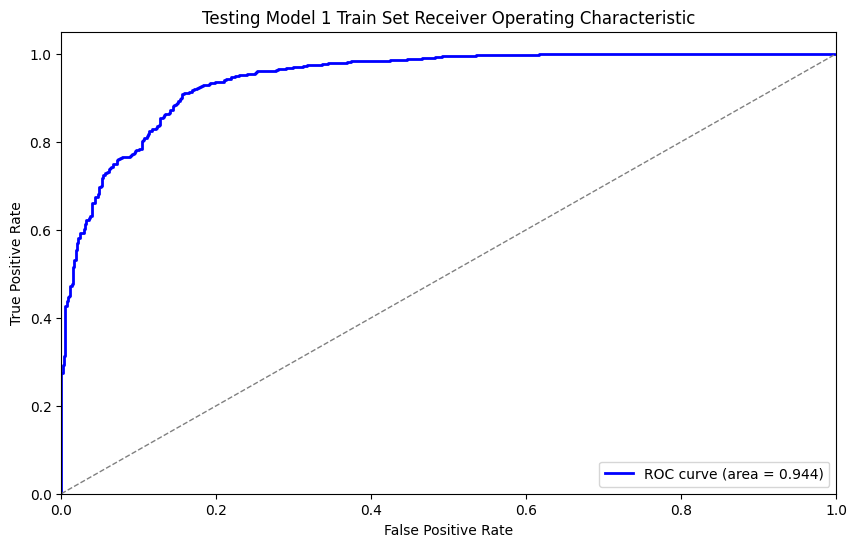

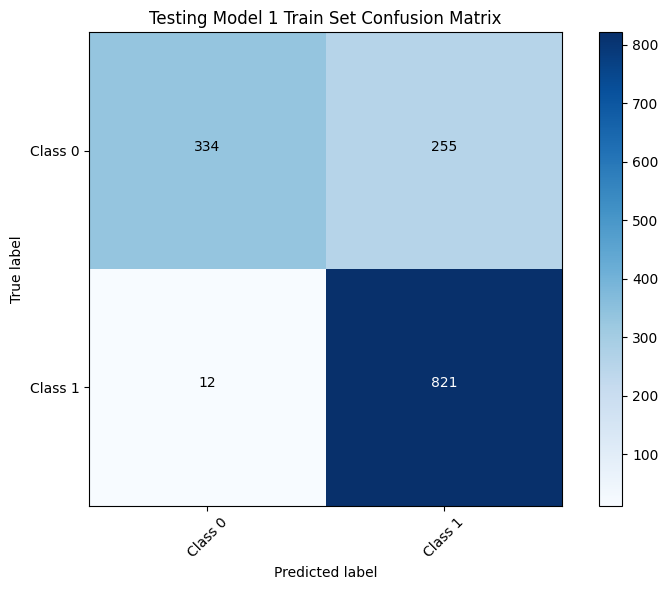

Accuracy: 81.22
Precision: 76.30
Recall: 98.56
F1 Score: 0.860
AUC: 0.944
Loss: 0.382
Evaluating Testing Model 1 on Validation set...
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.7540 - loss: 0.4900
Test accuracy: 0.7658227682113647 Test loss: 0.4919692873954773
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


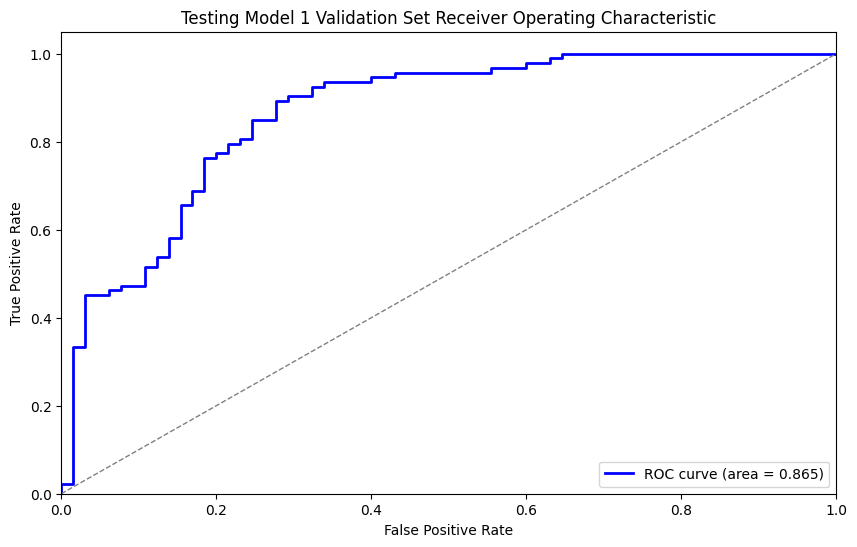

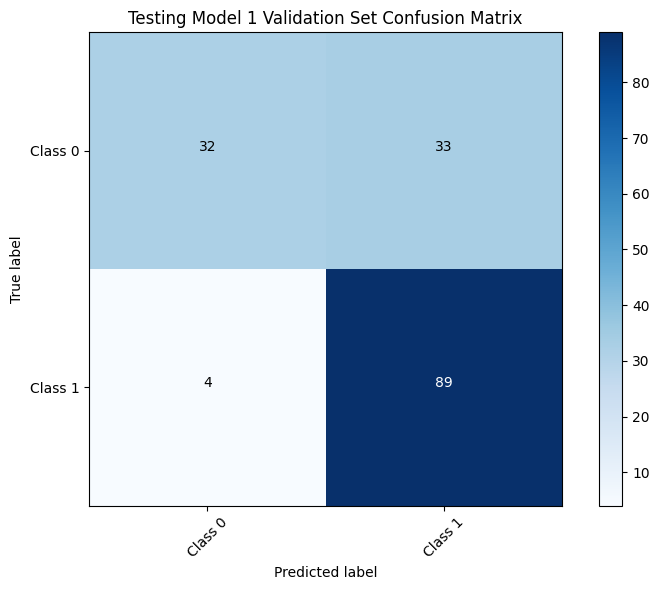

Accuracy: 76.58
Precision: 72.95
Recall: 95.70
F1 Score: 0.828
AUC: 0.865
Loss: 0.492
Evaluating Testing Model 1 on Test set...
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.7579 - loss: 0.5520 
Test accuracy: 0.761904776096344 Test loss: 0.5437968969345093
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step 


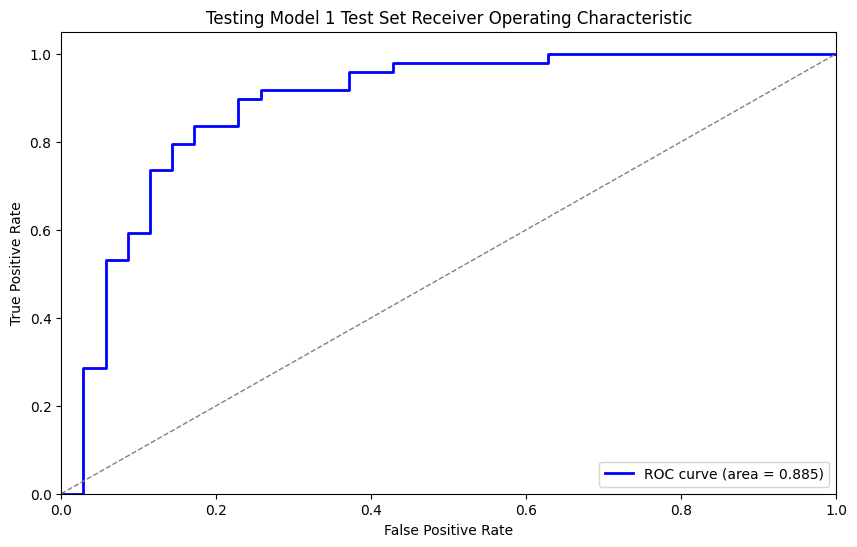

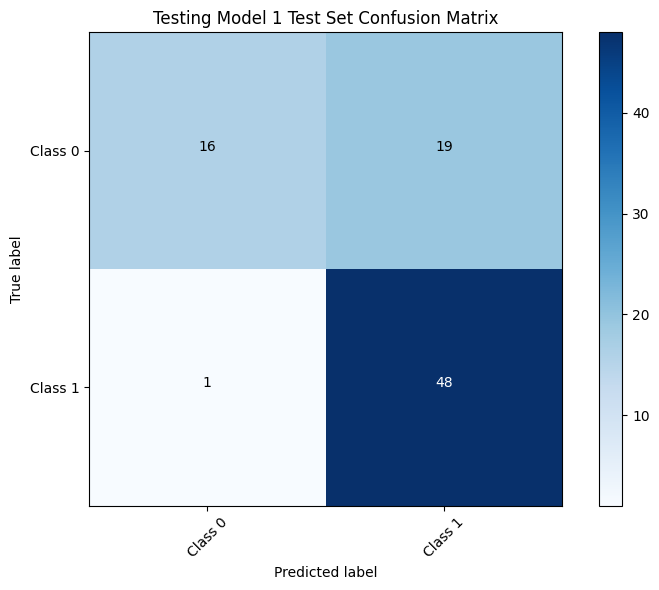

Accuracy: 76.19
Precision: 71.64
Recall: 97.96
F1 Score: 0.828
AUC: 0.885
Loss: 0.544
Plotting history for Testing Model 1...


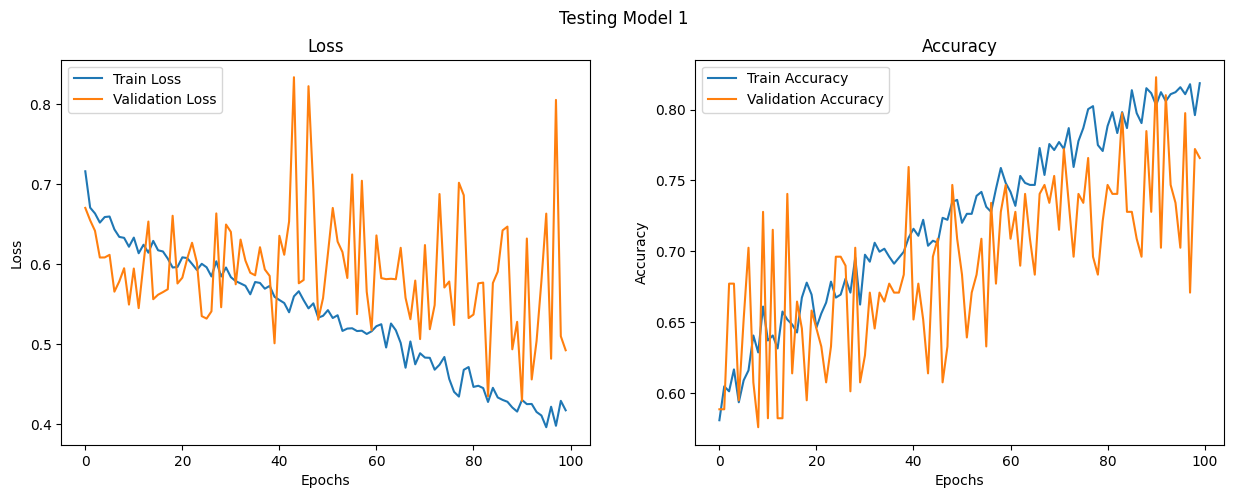

Training Testing Model 2...
Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 672ms/step - accuracy: 0.5480 - loss: 0.7780
Epoch 1: val_loss did not improve from 0.33084
23/23 ━━━━━━━━━━━━━━━━━━━━ 18s 698ms/step - accuracy: 0.5491 - loss: 0.7757 - val_accuracy: 0.5886 - val_loss: 0.6671
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 681ms/step - accuracy: 0.6111 - loss: 0.6659
Epoch 2: val_loss did not improve from 0.33084
23/23 ━━━━━━━━━━━━━━━━━━━━ 20s 698ms/step - accuracy: 0.6101 - loss: 0.6661 - val_accuracy: 0.5886 - val_loss: 0.6505
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 686ms/step - accuracy: 0.5987 - loss: 0.6556
Epoch 3: val_loss did not improve from 0.33084
23/23 ━━━━━━━━━━━━━━━━━━━━ 20s 703ms/step - accuracy: 0.5986 - loss: 0.6557 - val_accuracy: 0.6076 - val_loss: 0.5884
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 677ms/step - accuracy: 0.6258 - loss: 0.6478
Epoch 4: val_loss did not improve from 0.33084
23/23 ━━━━━━━━━━━━━━━━━━━━ 20s 695ms/step - accuracy: 0.6251 - loss: 0.6481 - val_

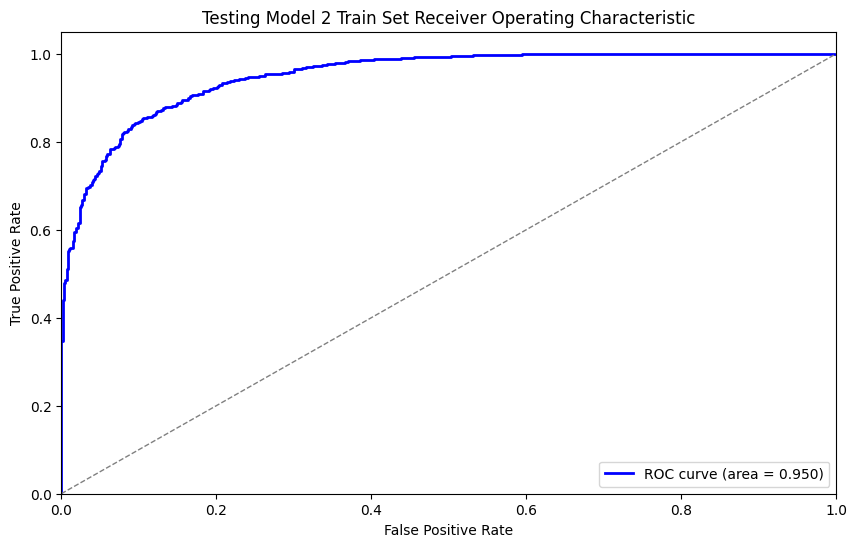

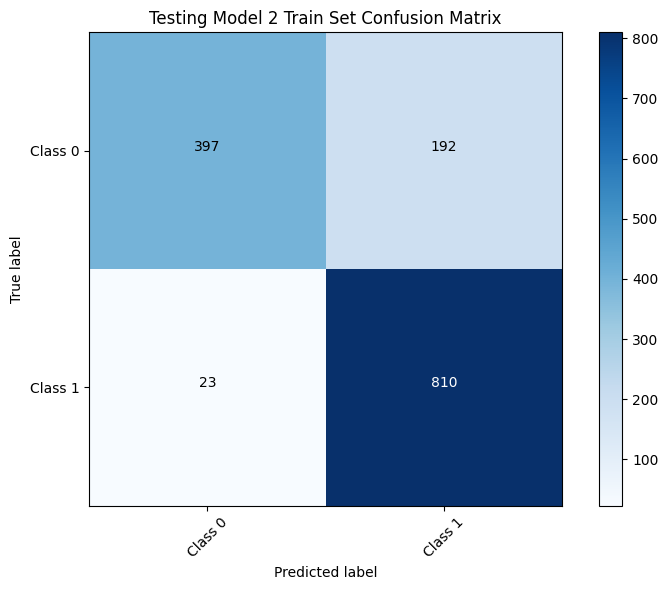

Accuracy: 84.88
Precision: 80.84
Recall: 97.24
F1 Score: 0.883
AUC: 0.950
Loss: 0.322
Evaluating Testing Model 2 on Validation set...
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.7791 - loss: 0.4503
Test accuracy: 0.7848101258277893 Test loss: 0.44799670577049255
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


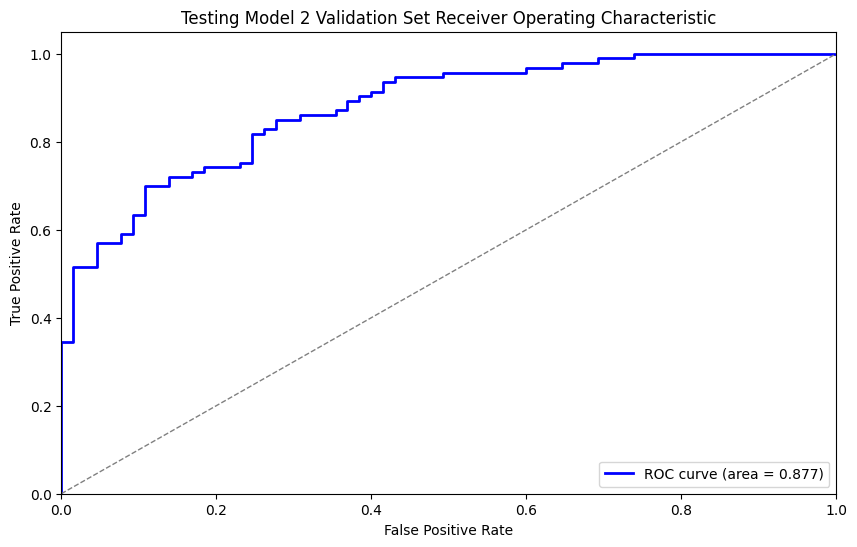

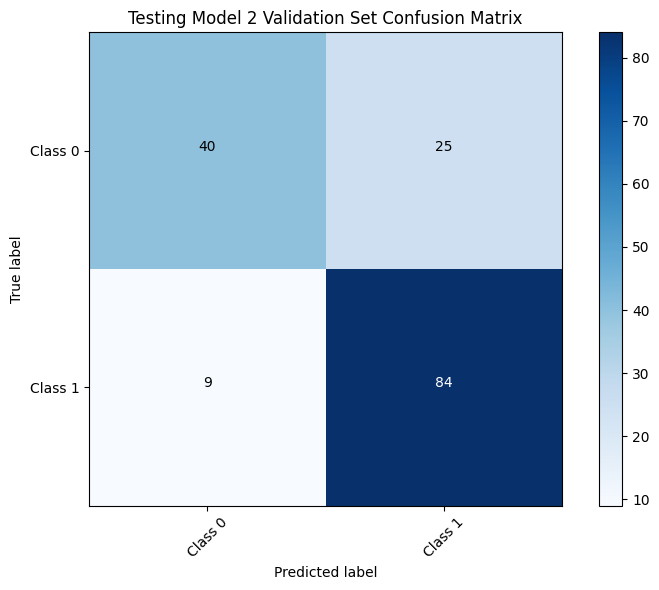

Accuracy: 78.48
Precision: 77.06
Recall: 90.32
F1 Score: 0.832
AUC: 0.877
Loss: 0.448
Evaluating Testing Model 2 on Test set...
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.8289 - loss: 0.3567
Test accuracy: 0.8214285969734192 Test loss: 0.3767196834087372
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


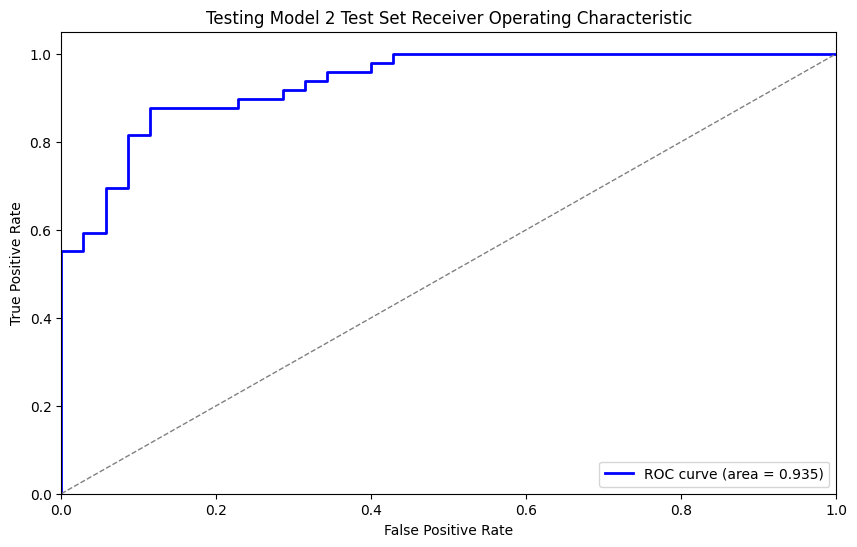

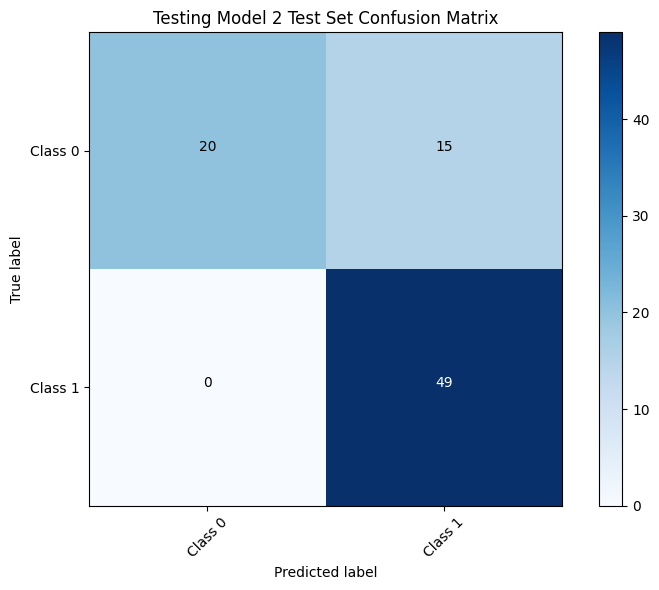

Accuracy: 82.14
Precision: 76.56
Recall: 100.00
F1 Score: 0.867
AUC: 0.935
Loss: 0.377
Plotting history for Testing Model 2...


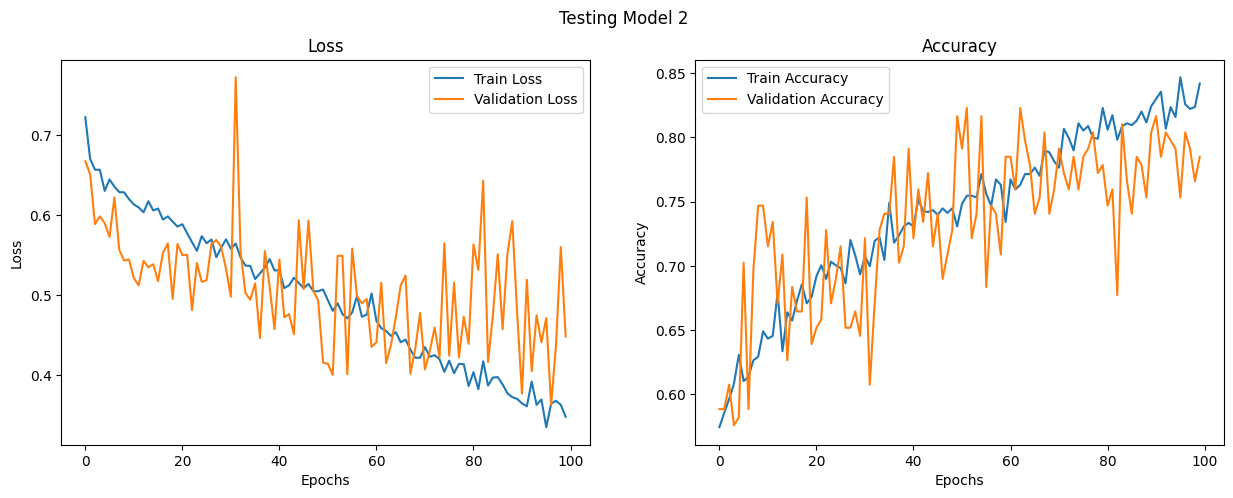

In [ ]:












# Display class distribution before augmentation
sns.countplot(x=np.argmax(y_train, 1))
plt.title('Class Distribution Before Augmentation')
plt.show()

batch_size = 64

# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
train_datagen_test = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow(X_train, y_train, batch_size=batch_size)
train_generator_test = train_datagen_test.flow(X_train, y_train, batch_size=batch_size)

val_generator = val_datagen.flow(X_val, y_val, batch_size=batch_size)
test_generator = test_datagen.flow(X_test, y_test, batch_size=batch_size)

# Display class distribution after augmentation
augmented_images, _ = next(train_generator)

augmented_labels = []
for _ in range((len(y_train)*5 // batch_size)+1):
    _, batch_labels = next(train_generator)
    augmented_labels.extend(batch_labels)
sns.countplot(x=np.argmax(augmented_labels, 1))
plt.title('Class Distribution After Augmentation')
plt.show()

# Display 5 random augmented images
fig, axes = plt.subplots(1, 5, figsize=(20, 5))
for i in range(5):
    random_index = np.random.randint(0, len(augmented_images))
    ax = axes[i]
    ax.imshow(augmented_images[random_index])
    ax.axis('off')
plt.show()

# Define models
proposed_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(2, activation='softmax')
])

testing_model_1 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(2, activation='softmax')
])

testing_model_2 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(2, activation='softmax')
])

models = {
    "Proposed Model": proposed_model,
    "Testing Model 1": testing_model_1,
    "Testing Model 2": testing_model_2
}

checkpoint_path = 'best_model.keras'  # Updated to use .keras extension
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_best_only=True,
    monitor='val_loss',
    mode='min',
    verbose=1
)

def compile_and_train(model, train_generator, val_generator, checkpoint_callback, epochs=100):
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    history = model.fit(train_generator,
                        epochs=epochs,
                        validation_data=val_generator,
                        callbacks=[checkpoint_callback])
    return history

def plot_history(name, history):
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    fig.suptitle(name)
    axs[0].plot(history.history['loss'], label='Train Loss')
    axs[0].plot(history.history['val_loss'], label='Validation Loss')
    axs[0].set_title('Loss')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Loss')
    axs[0].legend()
    axs[1].plot(history.history['accuracy'], label='Train Accuracy')
    axs[1].plot(history.history['val_accuracy'], label='Validation Accuracy')
    axs[1].set_title('Accuracy')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend()
    plt.show()

def evaluate_and_plot_confusion_matrix(name, model, generator, y):
    test_loss, test_acc = model.evaluate(generator)
    print(f"Test accuracy: {test_acc}", f"Test loss: {test_loss}")

    Y_true = []
    test_generator.reset()
    for _ in range((len(y) // batch_size)+1):
        _, batch_labels = next(generator)
        Y_true.extend(batch_labels)
    Y_true = np.argmax(Y_true, 1)

    generator.reset()
    Y_pred = model.predict(generator)
    Y_pred_classes = np.argmax(Y_pred, 1)

    fpr, tpr, _ = roc_curve(Y_true, Y_pred[:, 1])
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(name + ' Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.show()

    conf_matrix = confusion_matrix(Y_true, Y_pred_classes)
    plt.figure(figsize=(8, 6))
    plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(name + ' Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['Class 0', 'Class 1'], rotation=45)
    plt.yticks(tick_marks, ['Class 0', 'Class 1'])
    thresh = conf_matrix.max() / 2.
    for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if conf_matrix[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

    accuracy = accuracy_score(Y_true, Y_pred_classes)
    precision = precision_score(Y_true, Y_pred_classes)
    recall = recall_score(Y_true, Y_pred_classes)
    f1 = f1_score(Y_true, Y_pred_classes)
    print(f'Accuracy: {accuracy*100:.2f}')
    print(f'Precision: {precision*100:.2f}')
    print(f'Recall: {recall*100:.2f}')
    print(f'F1 Score: {f1:.3f}')
    print(f'AUC: {roc_auc:.3f}')
    print(f"Loss: {test_loss:.3f}")

# Training, evaluation, and plotting for each model
for model_name, model in models.items():
    print(f"Training {model_name}...")
    history = compile_and_train(model, train_generator, val_generator, checkpoint_callback)

    print(f"Evaluating {model_name} on Train set...")
    evaluate_and_plot_confusion_matrix(model_name + ' Train Set', model, train_generator_test, y_train)

    print(f"Evaluating {model_name} on Validation set...")
    evaluate_and_plot_confusion_matrix(model_name + ' Validation Set',model, val_generator, y_val)

    print(f"Evaluating {model_name} on Test set...")
    evaluate_and_plot_confusion_matrix(model_name + ' Test Set',model, test_generator, y_test)

    print(f"Plotting history for {model_name}...")
    plot_history(model_name, history)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Training Proposed Model with DropOut and Glorot Initializer...
Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5589 - loss: 0.6833
Epoch 1: val_loss did not improve from 0.33084
23/23 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.5595 - loss: 0.6834 - val_accuracy: 0.5886 - val_loss: 0.6852
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6082 - loss: 0.6812
Epoch 2: val_loss did not improve from 0.33084
23/23 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.6073 - loss: 0.6812 - val_accuracy: 0.5886 - val_loss: 0.6797
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5903 - loss: 0.6716
Epoch 3: val_loss did not improve from 0.33084
23/23 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.5902 - loss: 0.6716 - val_accuracy: 0.5759 - val_loss: 0.6593
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5542 - loss: 0.6907
Epoch 4: val_loss did not improve from 0.33084
23/23 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.5551 - loss: 0.

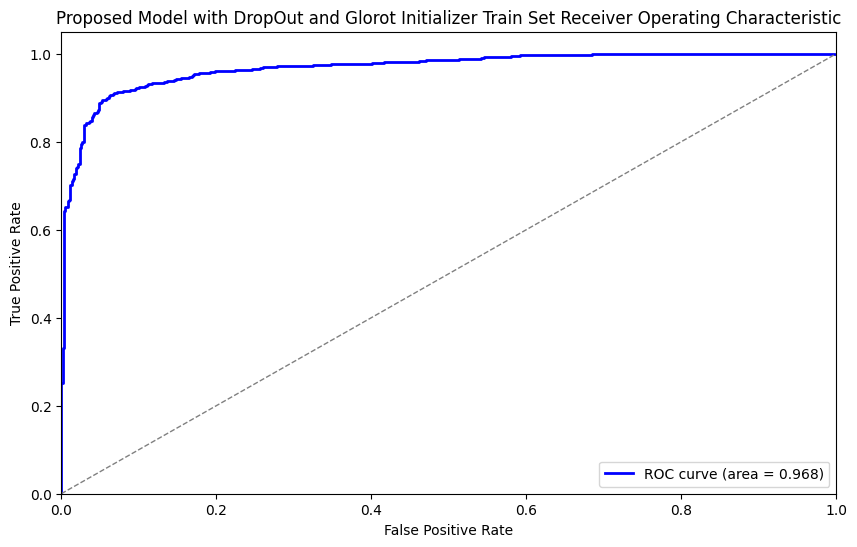

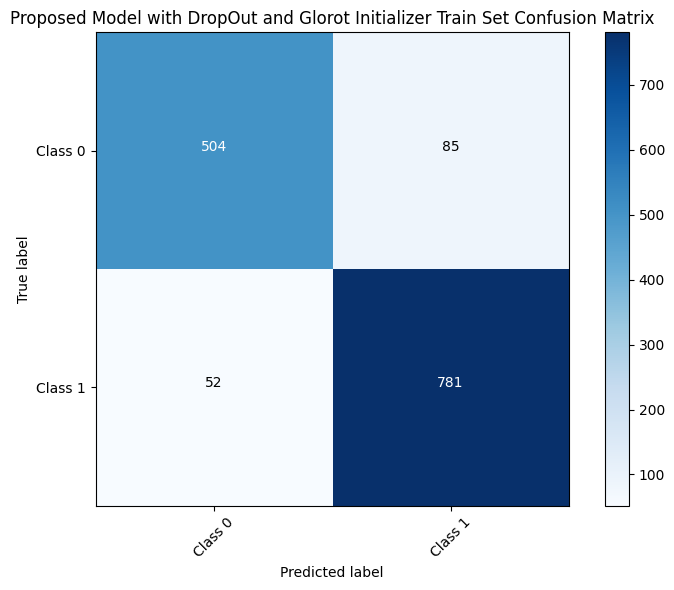

Accuracy: 90.37
Precision: 90.18
Recall: 93.76
F1 Score: 0.919
AUC: 0.968
Loss: 0.240
Evaluating Proposed Model with DropOut and Glorot Initializer on Validation set...
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 176ms/step - accuracy: 0.8035 - loss: 0.3915
Test accuracy: 0.8101266026496887 Test loss: 0.3802192211151123
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 179ms/step


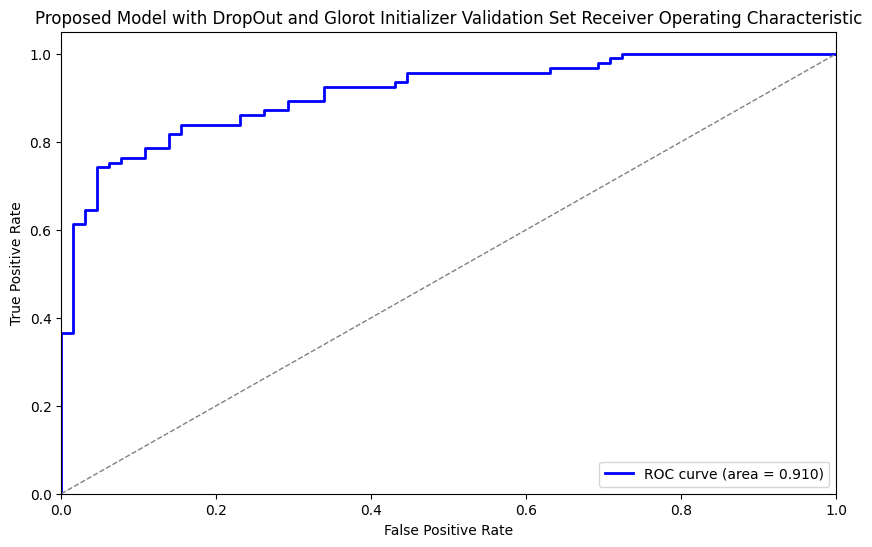

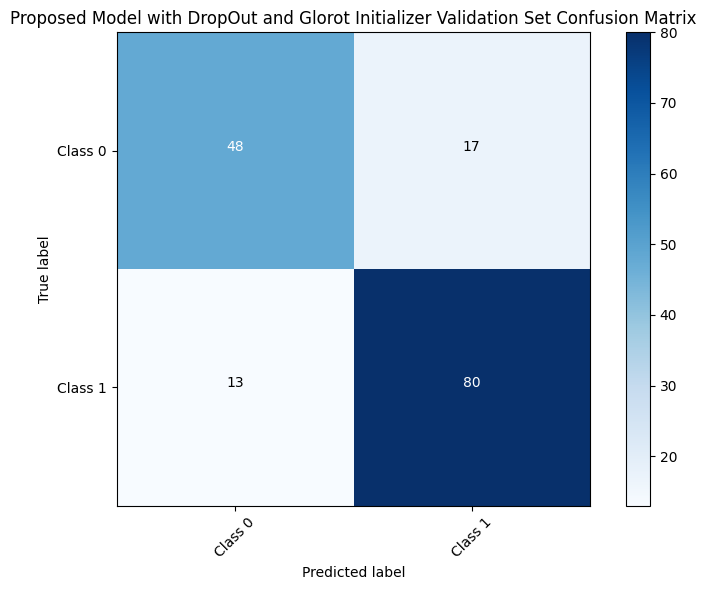

Accuracy: 81.01
Precision: 82.47
Recall: 86.02
F1 Score: 0.842
AUC: 0.910
Loss: 0.380
Evaluating Proposed Model with DropOut and Glorot Initializer on Test set...
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.8185 - loss: 0.4032
Test accuracy: 0.8214285969734192 Test loss: 0.3950835168361664
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


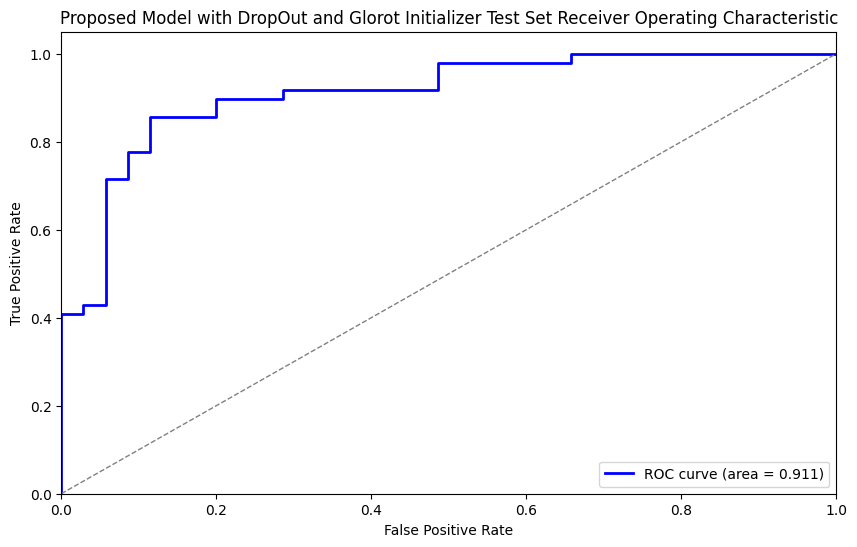

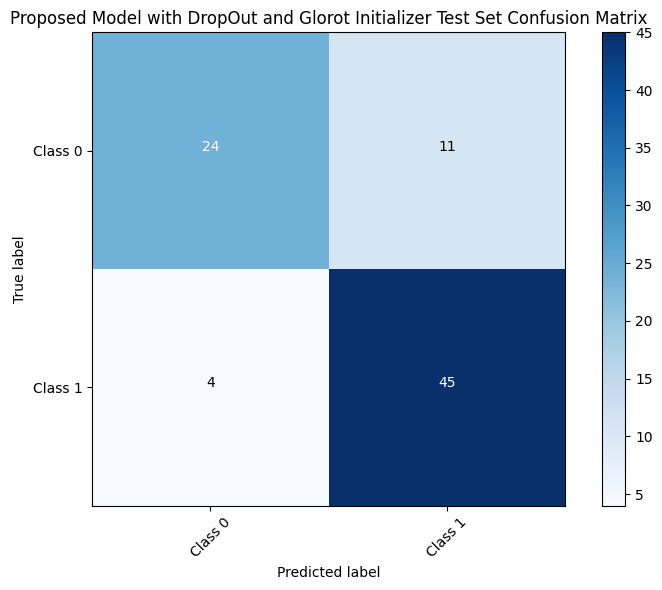

Accuracy: 82.14
Precision: 80.36
Recall: 91.84
F1 Score: 0.857
AUC: 0.911
Loss: 0.395
Plotting history for Proposed Model with DropOut and Glorot Initializer...


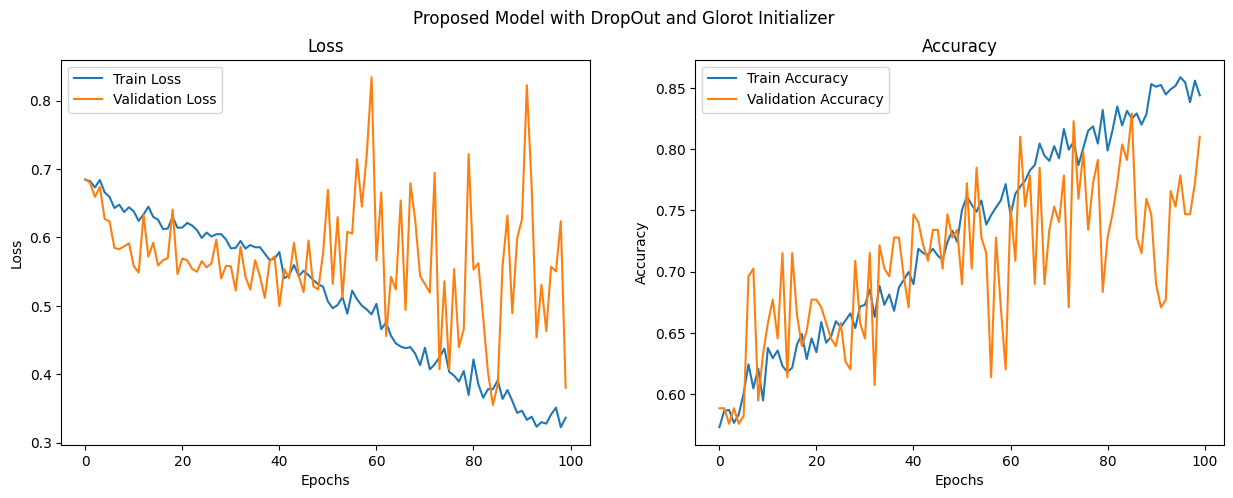

In [ ]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    Dropout(0.2),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    Dropout(0.2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu', kernel_initializer=tf.keras.initializers.GlorotUniform()),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(2, activation='softmax')
])

model_name = 'Proposed Model with DropOut and Glorot Initializer'
print(f"Training {model_name}...")
history = compile_and_train(model, train_generator, val_generator, checkpoint_callback)

print(f"Evaluating {model_name} on Train set...")
evaluate_and_plot_confusion_matrix(model_name + ' Train Set', model, train_generator_test, y_train)

print(f"Evaluating {model_name} on Validation set...")
evaluate_and_plot_confusion_matrix(model_name + ' Validation Set',model, val_generator, y_val)

print(f"Evaluating {model_name} on Test set...")
evaluate_and_plot_confusion_matrix(model_name + ' Test Set',model, test_generator, y_test)

print(f"Plotting history for {model_name}...")
plot_history(model_name, history)

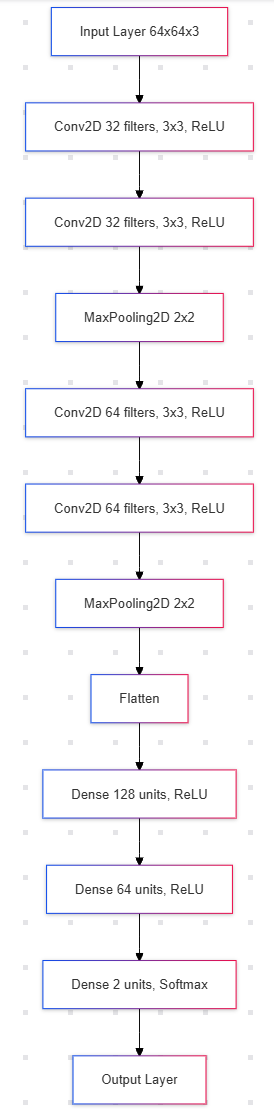